# Условие
$$ c_2 = 0.85, A = 2, B = -2, C = 3, \text{метод-оппонент -- Метод "Симпсона" порядка 3} $$

1. Построить расчетную схему второго порядка для численного решения данной системы, используя условия порядка для двухэтапного ЯМРК. Конкретное значение параметра $c_2 = 0.85$
2. Метод-оппонент -- метод "Симпсона" 3 порядка.
3. Реализовать алгоритмы обоих методов, провести сравнительный анализ полученных результатов с точным решением:
$$ \begin{cases}
y_1'(x) = 2x( y_2(x)) ^{\frac{1}{B}}y_4(x), \\ \\
y_2'(x) = 2Bx \exp\left(\frac{B}{C}(y_3(x)-A)\right)y_4(x), \\ \\
y_3'(x) = 2Cx y_4(x), \\ \\
y_4'(x) = -2x \ln y_1(x),
\end{cases} $$
с начальными условиями $y_1(0) = y_2(0) = y_4(0) = 1, \quad y_3(0) = A$ на отрезке $x \in [0, 5]$. <br>
Точное решение задачи имеет вид:
$$ y_1(x) = e^{\sin x^2}, \quad y_2(x) = e^{B \sin x^2}, \quad y_3(x) = C \sin x^2 + A, \quad y_4(x) = \cos x^2. $$

- С постоянным шагом
- Реализовать автоматический выбор длины шага для 2-х методов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import typing
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Параметры задачи
A, B, C = 2, -2, 3
x0, y0 = 0, [1, 1, A, 1]
x_end = 5
tol = 1e-5

In [3]:
# Точное решение
def exact_solution(x):
    y1 = np.exp(np.sin(x ** 2))
    y2 = np.exp(B * np.sin(x ** 2))
    y3 = C * np.sin(x ** 2) + A
    y4 = np.cos(x ** 2)
    return y1, y2, y3, y4

In [4]:
def system(x, y):
    y1, y2, y3, y4 = y
    eps = 1e-10  # Малое значение для предотвращения некорректных операций
    # y1 = max(y1, eps)
    # y2 = max(y2, eps)

    dydx = np.zeros_like(y)
    dydx[0] = 2 * x * y2 ** (1 / B) * y4

    exp_value = np.exp((B / C) * (y3 - A))
    # exp_value = np.clip(np.exp((B / C) * (y3 - A)), -1e15, 1e10)
    dydx[1] = 2 * B * x * exp_value * y4
    dydx[2] = 2 * C * x * y4
    dydx[3] = -2 * x * np.log(y1)
    return dydx

In [5]:
# ЯМРК второго порядка
def runge_kutta_2nd_order(f, x_0, y_0, h, n_steps, c2=0.85):
    a21 = c2
    b1 = 1 - (1 / (2 * c2))
    b2 = 1 / (2 * c2)
    x = x_0
    y = np.array(y_0)
    ys = [y_0]
    xs = [x_0]

    for _ in range(n_steps):
        k1 = f(x, y)

        # y_for_k2 = [item + h * a21 * k1 for item in y ]
        k2 = f(x + c2 * h, y + h * a21 * k1)
        # k2 = f(x + c2 * h, y_for_k2)
        y = y + h * (b1 * k1 + b2 * k2)
        x += h
        ys.append(y)
        xs.append(x)
    return np.array(xs), np.array(ys)

In [6]:
# Метод Симпсона
def simpson_method(f, x_0, y_0, h, n_steps):
    x = x_0
    y = np.array(y_0)
    ys = [y_0]
    xs = [x_0]

    for _ in range(n_steps):
        k1 = f(x, y)
        k2 = f(x + h / 2, y + h * k1 / 2)
        k3 = f(x + h, y - h * k1 + 2 * h * k2)
        y = y + h * (k1 + 4 * k2 + k3) / 6
        x += h
        ys.append(y)
        xs.append(x)
    return np.array(xs), np.array(ys)

In [7]:
df_example = pd.DataFrame([{'A': 1, "B": 2}, {'A': 9, "B": 0}])
df_example.iloc[-1]['A']

9

In [7]:
def estimation_total_error_end_segment(x_fin=x_end, p_rk=2, p_sim=3):
    df_runge = pd.DataFrame(columns=['length_step', 'x_0', 'result_method_x_end', 'total_error'])
    df_simpson = pd.DataFrame(columns=['length_step', 'x_0', 'result_method_x_end', 'total_error'])

    for k in range(7):  # k = 0, ..., 6
        h = 1 / 2 ** (k + 4)
        x_0 = x0
        y_0 = exact_solution(x_0)
        n_steps = int((x_end - x_0) / h)

        # Вычислим приближённое значение в точке x_end с помощью метода РК
        x_rk, y_rk = runge_kutta_2nd_order(system, x_0, y_0, h, n_steps)

        # Вычислим приближённое значение в точке x_end с помощью метода Симпсона
        x_sim, y_sim = simpson_method(system, x_0, y_0, h, n_steps)

        # Приближенное значение в точке x_end
        value_at_the_end_rk = y_rk[-1]
        value_at_the_end_sim = y_sim[-1]

        if k == 1:
            # Вычисляем погрешность для шага h = 1, т.е. при k = 0
            error_rk_0 = np.linalg.norm((value_at_the_end_rk - df_runge.iloc[-1]['result_method_x_end']) / (1 - 2 ** (-p_rk)))
            error_sim_0 = np.linalg.norm((value_at_the_end_sim - df_simpson.iloc[-1]['result_method_x_end']) / (1 - 2 ** (-p_sim)))

            # Вычисляем погрешность для шага h = 1/2, т.е. при k = 1
            error_rk_1 = np.linalg.norm((value_at_the_end_rk - df_runge.iloc[-1]['result_method_x_end']) / (2 ** p_rk - 1))
            error_sim_1 = np.linalg.norm((value_at_the_end_sim - df_simpson.iloc[-1]['result_method_x_end']) / (2 ** p_sim - 1))

            # Заполняем в датафрейме total_error для k = 0
            df_runge.at[0, 'total_error'] = error_rk_0
            df_simpson.at[0, 'total_error'] = error_sim_0

            df_runge = pd.concat([df_runge, pd.DataFrame([[h, x_0, value_at_the_end_rk, error_rk_1]], columns=df_runge.columns)], ignore_index=True)
            df_simpson = pd.concat([df_simpson, pd.DataFrame([[h, x_0, value_at_the_end_sim, error_sim_1]], columns=df_simpson.columns)], ignore_index=True)

        elif k >= 2:
            error_rk_1 = np.linalg.norm((value_at_the_end_rk - df_runge.iloc[-1]['result_method_x_end']) / (2 ** p_rk - 1))
            error_sim_1 = np.linalg.norm((value_at_the_end_sim - df_simpson.iloc[-1]['result_method_x_end']) / (2 ** p_sim - 1))

            df_runge = pd.concat([df_runge, pd.DataFrame([[h, x_0, value_at_the_end_rk, error_rk_1]], columns=df_runge.columns)], ignore_index=True)
            df_simpson = pd.concat([df_simpson, pd.DataFrame([[h, x_0, value_at_the_end_sim, error_sim_1]], columns=df_simpson.columns)], ignore_index=True)

        else:
            new_row_rk = pd.DataFrame([[h, x_0, value_at_the_end_rk, 0]], columns=df_runge.columns)
            df_runge = pd.concat([df_runge, new_row_rk], ignore_index=True)


            new_row_sim = pd.DataFrame([[h, x_0, value_at_the_end_sim, 0]], columns=df_simpson.columns)
            df_simpson = pd.concat([df_simpson, new_row_sim], ignore_index=True)


    return df_runge, df_simpson


In [8]:
df_runge_error, df_simpson_error = estimation_total_error_end_segment()

C:\Users\ooood\AppData\Local\Temp\ipykernel_33516\3028784461.py:8: RuntimeWarning: invalid value encountered in scalar power
  dydx[0] = 2 * x * y2 ** (1 / B) * y4


In [9]:
df_runge_error

,length_step,x_0,result_method_x_end,total_error
0,0.062500,0,"[nan, nan, nan, nan]",NaN
1,0.031250,0,"[1.9740705504670002, 0.1947335859355891, 3.356...",NaN
2,0.015625,0,"[1.0478672170328298, 0.8956560627558269, 2.120...",0.566092
3,0.007812,0,"[0.9145653455640528, 1.191208294502035, 1.7321...",0.168736
4,0.003906,0,"[0.8853988526933254, 1.2744545434856123, 1.635...",0.043683
5,0.001953,0,"[0.8783556725623047, 1.2958628985349614, 1.611...",0.011039
6,0.000977,0,"[0.8766120445498223, 1.3012478435416133, 1.604...",0.002769


In [10]:
df_simpson_error

,length_step,x_0,result_method_x_end,total_error
0,0.062500,0,"[0.7543484277143984, 2.0454074464068293, 1.154...",1.07671
1,0.031250,0,"[0.8839633345677985, 1.2795207458048572, 1.679...",0.134589
2,0.015625,0,"[0.8786074873894838, 1.2933041632957472, 1.620...",0.008796
3,0.007812,0,"[0.8763742894225155, 1.301694529839792, 1.6053...",0.00252
4,0.003906,0,"[0.8760734817508731, 1.3028802048362953, 1.603...",0.000345
5,0.001953,0,"[0.8760376542503043, 1.3030246929380607, 1.602...",0.000042
6,0.000977,0,"[0.876033386104152, 1.303042136026689, 1.60294...",0.000005


In [11]:
# Построим график
def plot_errors(df_runge, df_simpson, p_rk=2, p_sim=3):
    plt.figure(figsize=(10, 6))

    # Погрешности
    h_rk = df_runge['length_step'].astype(float)
    error_rk = df_runge['total_error'].astype(float)
    h_sim = df_simpson['length_step'].astype(float)
    error_sim = df_simpson['total_error'].astype(float)

    # Графики ошибок
    plt.loglog(h_rk, error_rk, 'o-', label=f'RK (порядок {p_rk})')
    plt.loglog(h_sim, error_sim, 's-', label=f'Simpson (порядок {p_sim})')

    # Прямые с наклоном
    h_ref = np.logspace(-3, 0, 100)
    plt.loglog(h_ref, h_ref**p_rk * error_rk.iloc[2] / h_rk.iloc[2]**p_rk, '--', label=f'Сходимость O(h^{p_rk})')
    plt.loglog(h_ref, h_ref**p_sim * error_sim.iloc[2] / h_sim.iloc[2]**p_sim, '--', label=f'Сходимость O(h^{p_sim})')

    # Настройки графика
    plt.xlabel('Длина шага h')
    plt.ylabel('Точная полная погрешность')
    plt.title('Сходимость методов')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()



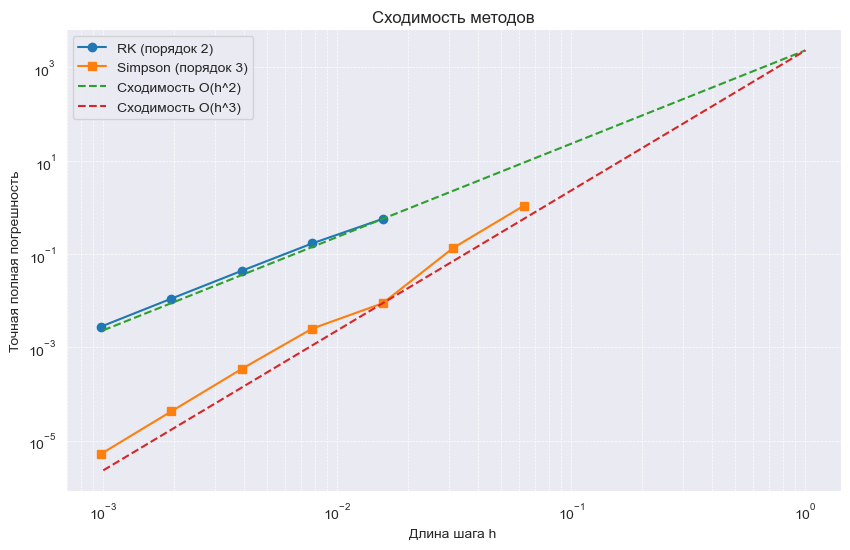

In [12]:
# Построим график
plot_errors(df_runge_error, df_simpson_error)

In [13]:
def h_opt(tol, h, R_n, p):
    answer = h * (tol/ R_n) ** (1/p)
    return answer

In [14]:
def calculation_with_h_opt():
    # Вычисление h_opt
    h_opt_rk = h_opt(1e-5, df_runge_error.loc[4, "length_step"], df_runge_error.loc[4, "total_error"], 2)
    h_opt_sim = h_opt(1e-5, df_simpson_error.loc[5, "length_step"], df_simpson_error.loc[5, "total_error"], 3)

    # Вычисление числа этапов
    number_steps_rk = int((x_end - x0) / h_opt_rk)
    number_steps_sim = int((x_end - x0) / h_opt_sim)

    # Вычисление численных методов с оптимальным шагом
    x_rk, y_rk = runge_kutta_2nd_order(system, x0, y0, h_opt_rk, number_steps_rk)
    x_sim, y_sim = simpson_method(system, x0, y0, h_opt_sim, number_steps_sim)

    # Вычисление точного решения для x_rk, x_sim, где каждому x --> [y_1, y_2, y_3, y_4]
    y_exact_rk = np.array([exact_solution(x) for x in x_rk])
    y_exact_sim = np.array([exact_solution(x) for x in x_sim])

    # Находим норму полной погрешности
    norm_rk = np.linalg.norm(y_rk - y_exact_rk, axis=1)
    norm_sim = np.linalg.norm(y_sim - y_exact_sim, axis=1)

    return x_rk, x_sim, norm_rk, norm_sim


In [15]:
def plot_norms(x_rk, norm_rk, x_sim, norm_sim):
    plt.figure(figsize=(10, 6))

    # Графики норм погрешностей
    plt.plot(x_rk, norm_rk, label='Норма погрешности RK', linewidth=1)
    plt.plot(x_sim, norm_sim, label='Норма погрешности Simpson', linewidth=1)

    # Настройки графика
    plt.xlabel('x')
    plt.ylabel('Норма полной погрешности')
    plt.title('Норма погрешности методов')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


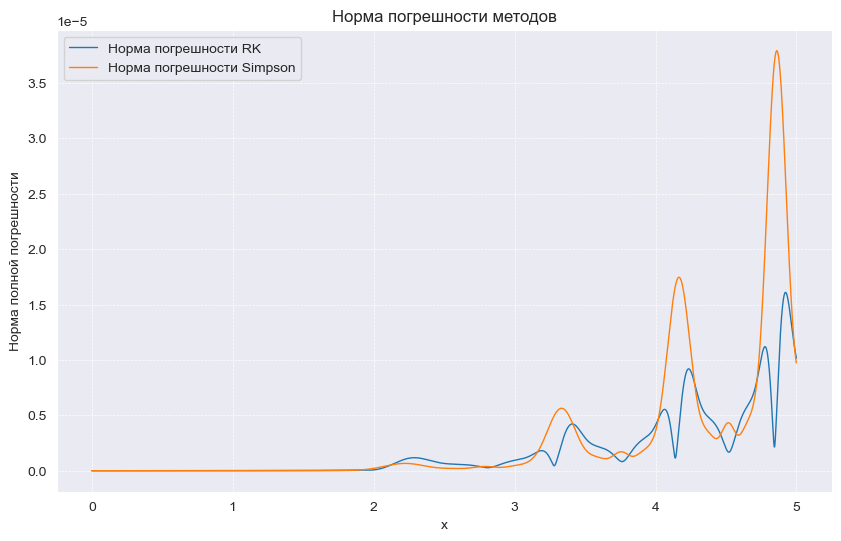

In [16]:
# Вычислим значения и построим график
x_rk, x_sim, norm_rk, norm_sim = calculation_with_h_opt()
plot_norms(x_rk, norm_rk, x_sim, norm_sim)

In [17]:
def choosing_the_initial_step(tol, p):
    """
    Выбор начального шага для вычисления автоматического шага
    :param tol: Точность
    :param p: Порядок
    :return: Начальный шаг
    """

    #Первый этап вычисления
    delta_1 = (1 / max( abs(x0), abs(x_end) )) ** (p + 1) + np.linalg.norm(system(x0, y0)) ** (p + 1)
    h_1 = (tol / delta_1) ** (1 / (p + 1))

    #Проводим вычисления для новой точки
    x1 = x0 + h_1
    u1 = exact_solution(x1)
    delta_2 = (1 / max( abs(x1), abs(x_end) )) ** (p + 1) + np.linalg.norm(system(x1, u1)) ** (p + 1)
    h_2 = (tol / delta_2) ** (1 / (p + 1))

    return min(h_1, h_2)

In [18]:
def auto_step_calculation(p = None, rtol = None, hmax = None, method = None, atol = 1e-12):
    counter = 0
    tol = rtol * np.linalg.norm(y0) + atol
    x_0_new = x0
    y_0_new = y0

    # Выбор начального шага
    h_st = choosing_the_initial_step(tol, p)

    # Заполнение датафрейма
    df_auto_step = pd.DataFrame(columns=['x', 'length_step', 'accepted'])
    # df_auto_step = pd.DataFrame([{'x': x0, 'length_step': h_st, 'accepted': False}])
    df_full_result = pd.DataFrame([{'x': x_0_new, 'y': y_0_new, 'error_local': 0}])


    while(x_0_new < x_end):
        # print(x_0_new)
        # x_0_new = x_end - h_st
        # y_0_new = exact_solution(x_0_new)
        # if (not df_auto_step.empty) and h_st != df_auto_step.at[-1, 'length_step'] :
        #     df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, False]], columns = df_auto_step.columns)], ignore_index=True)

        x_met_1, y_met_1 = method(system, x_0_new, y_0_new, h_st, 1)
        x_met_2, y_met_2 = method(system, x_0_new, y_0_new, h_st/2, 2)

        norm_loc_error = np.linalg.norm((y_met_1[-1] - y_met_2[-1]) / (1 - 2 ** (-p)))

        if norm_loc_error > tol * 2 ** p:
            # if counter != 0:
            #     # df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, False]], columns = df_auto_step.columns)])
            df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, False]], columns = df_auto_step.columns)], ignore_index=True)
            df_auto_step.at[-1, 'accepted'] = False
            h_st = h_st / 2
            print('Попали')
            # df_full_result.at[-1, 'x'] = x_0_new
            # df_full_result.at[-1, 'y'] = y_0_new

        elif tol < norm_loc_error <= tol * 2 ** p:
            # if counter != 0:
            #     df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, False]], columns = df_auto_step.columns)])

            df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)], ignore_index=True)

            x_0_new = x_0_new + h_st
            y_0_new = y_met_2[-1]
            df_full_result = pd.concat([df_full_result, pd.DataFrame([[x_0_new, y_0_new, norm_loc_error]], columns = df_full_result.columns)], ignore_index=True)

            h_st = h_st / 2

            # df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)])

        elif tol/2**(p+1) <= norm_loc_error <= tol:
            # if counter != 0:
            #     df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)])
            # else:
            #     df_auto_step.at[counter, 'accepted'] = True

            df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)], ignore_index=True)
            x_0_new = x_0_new + h_st
            y_0_new = y_met_1[-1]
            df_full_result = pd.concat([df_full_result, pd.DataFrame([[x_0_new, y_0_new, norm_loc_error]], columns = df_full_result.columns)], ignore_index=True)

        elif norm_loc_error < tol/2**(p+1):
            # if counter != 0:
            #     df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, False]], columns = df_auto_step.columns)])

            df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)], ignore_index=True)
            df_full_result = pd.concat([df_full_result, pd.DataFrame([[x_met_1[-1], y_met_1[-1], norm_loc_error]], columns = df_full_result.columns)], ignore_index=True)
            x_0_new = x_0_new + h_st
            y_0_new = y_met_1[-1]
            h_st = min(2*h_st, hmax)


            # df_auto_step = pd.concat([df_auto_step, pd.DataFrame([[x_0_new, h_st, True]], columns = df_auto_step.columns)])

        counter += 1

    return df_full_result, df_auto_step


In [19]:
def calcul_solution_with_auto_step(h_auto_step_rk, h_auto_step_sim, x_exact, y_exact):
    # Вычисление числа этапов
    number_step_rk = int((x_end - x0) / h_auto_step_rk)
    number_step_sim = int((x_end - x0) / h_auto_step_sim)

    # Вычисление численных методов с оптимальным шагом
    x_rk, y_rk = runge_kutta_2nd_order(system, x0, y0, h_auto_step_rk, number_step_rk)
    x_sim, y_sim = simpson_method(system, x0, y0, h_auto_step_sim, number_step_sim)


    plt.figure(figsize=(12, 8))
    labels = [r"$y_1$", r"$y_2$", r"$y_3$", r"$y_4$"]
    for i in range(4):
        # plt.plot(x_exact, y_exact[i], label=f"Exact {labels[i]}", linewidth=0.5)
        # plt.plot(x_rk, y_rk[:, i], 'o--', label=f"RK2 {labels[i]}", linewidth=0.5)
        plt.plot(x_sim, y_sim[:, i], 'x--', label=f"Simpson {labels[i]}", linewidth=0.5)

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Сравнение методов")
    plt.grid()
    plt.show()



In [20]:
# Вычисление точного решения
x_exact = np.linspace(x0, x_end, 1000)
y_exact = exact_solution(x_exact)

# Вычисление максимального значения автоматического шага
h_max_rk = df_runge_error.loc[4, "length_step"]
h_max_sim = df_simpson_error.loc[5, "length_step"]

# Вычисление автоматического шага
df_step_length_independent_variable_rk, df_auto_rk = auto_step_calculation(2, 1e-6, 1, runge_kutta_2nd_order)
df_step_length_independent_variable_sim, df_auto_sim = auto_step_calculation(3, 1e-6, 1, simpson_method)

# calcul_solution_with_auto_step(h_auto_step_rk, h_auto_step_sim, x_exact, y_exact)

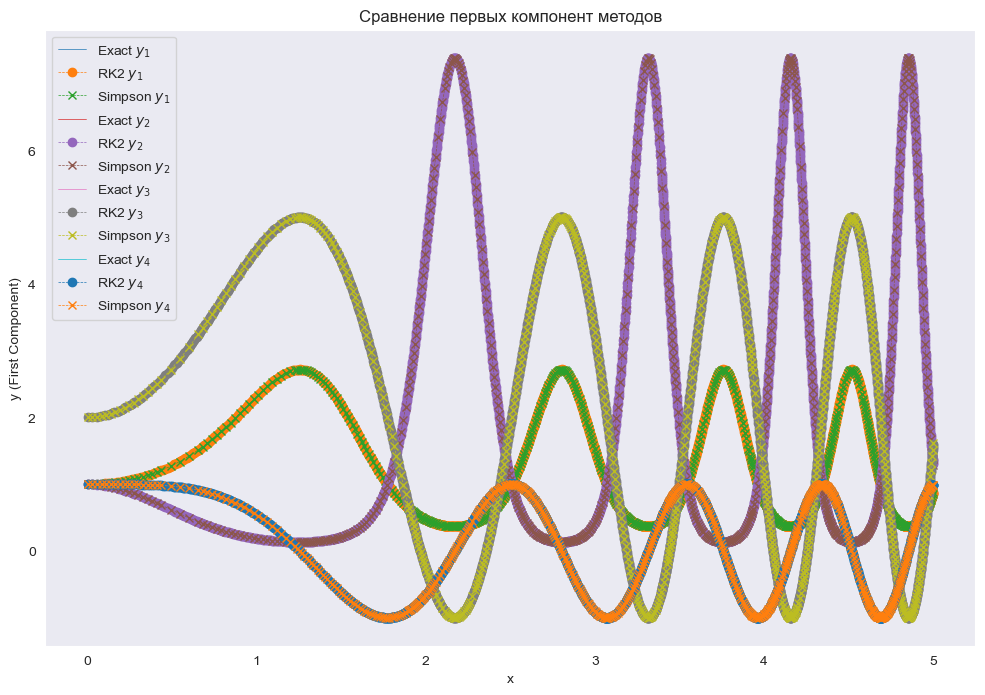

In [21]:
x_rk = df_step_length_independent_variable_rk["x"]
y_rk = df_step_length_independent_variable_rk["y"].values  # Преобразуем в массив NumPy

x_sim = df_step_length_independent_variable_sim["x"]
y_sim = df_step_length_independent_variable_sim["y"].values  # Преобразуем в массив NumPy

y_rk_full = []
y_sim_full = []
# Новые массивы из первых компонент
for i in range(4):
    y_rk_full.append([])
    for j in range(len(y_rk)):
        y_rk_full[i].append(y_rk[j][i])

for i in range(4):
    y_sim_full.append([])
    for j in range(len(y_sim)):
        y_sim_full[i].append(y_sim[j][i])

y_rk_full = np.array(y_rk_full)
y_sim_full = np.array(y_sim_full)
# y_rk_first = y_rk[:, 0]
# y_sim_first = y_sim[:, 0]

plt.figure(figsize=(12, 8))

# Метки для графиков
labels = [r"$y_1$", r"$y_2$", r"$y_3$", r"$y_4$"]

# График для первых компонент
for i in range(4):
    plt.plot(x_exact, y_exact[i], label=f"Exact {labels[i]}", linewidth=0.5)
    plt.plot(x_rk, y_rk_full[i, :], 'o--', label=f"RK2 {labels[i]}", linewidth=0.5)
    plt.plot(x_sim, y_sim_full[i, :], 'x--', label=f"Simpson {labels[i]}", linewidth=0.5)

plt.legend()
plt.xlabel("x")
plt.ylabel("y (First Component)")
plt.title("Сравнение первых компонент методов")
plt.grid()
plt.show()


In [22]:
df_auto_rk['accepted'].value_counts()

accepted
True    2632
Name: count, dtype: int64

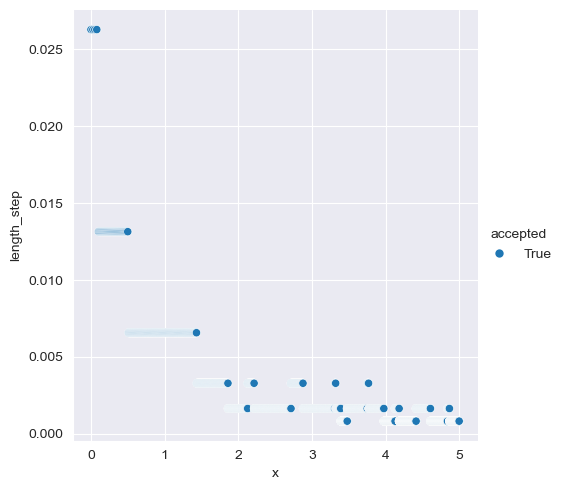

In [23]:
sns.relplot(data=df_auto_rk, x="x", y="length_step", hue="accepted", kind="scatter")


In [120]:
df_auto_sim['accepted'].value_counts()

accepted
True    668
Name: count, dtype: int64

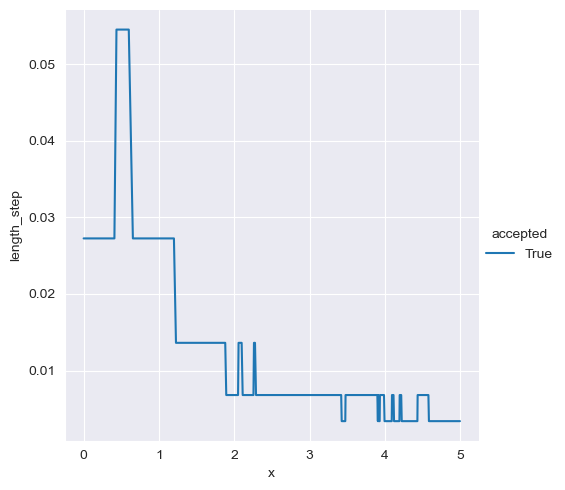

In [122]:
sns.relplot(data=df_auto_sim, x="x", y="length_step", hue="accepted", kind="line")